<a href="https://colab.research.google.com/github/Kgs-Mathaba/TensorFlow_Development_ZTM/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Oct 24 16:25:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    35W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#import helper script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-10-24 16:25:58--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-24 16:25:58 (55.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [4]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2021-10-24 16:26:01--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.147.128, 142.250.125.128, 142.250.136.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.147.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   176MB/s    in 8.6s    

2021-10-24 16:26:10 (180 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# ow many images/classes are there
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/garlic_bread'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fish_and_chips'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lobster_roll_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pulled_pork_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pork_chop'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beet_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_bolognese'.
There are 0 dire

In [6]:
#Setup data inputs
import tensorflow as tf
IMAGE_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                               label_mode="categorical",
                                                                               image_size = IMAGE_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size = IMAGE_SIZE,
                                                                shuffle=False) # for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


# Train a big dog model with transfer learning on 10% of 101 food classes

In [7]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only = True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)


In [8]:
# Create a data augmentation layer
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomWidth(0.2),
  #preprocessing.Rescalling(1/255.) # efficientNetBo already has scaling layer
], name="data_augmentation")

In [9]:
# Setup base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layer
inputs = layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_poll_layer")(x)
output = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
# Build model
model = tf.keras.Model(inputs, output)

16719872/16705208 [==============================] - 0s 0us/step


In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_avg_poll_layer (Globa (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [11]:
# Compile model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'],
              )

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs = 5,
                                           validation_data = test_data,
                                           validation_steps = int(0.15*len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 153s 496ms/step - loss: 3.4723 - accuracy: 0.2426 - val_loss: 2.6751 - val_accuracy: 0.4012
Epoch 2/5
237/237 [==============================] - 94s 396ms/step - loss: 2.3535 - accuracy: 0.4609 - val_loss: 2.2432 - val_accuracy: 0.4624
Epoch 3/5
237/237 [==============================] - 85s 358ms/step - loss: 1.9673 - accuracy: 0.5304 - val_loss: 2.0545 - val_accuracy: 0.4907
Epoch 4/5
237/237 [==============================] - 81s 338ms/step - loss: 1.7511 - accuracy: 0.5813 - val_loss: 1.9721 - val_accuracy: 0.4947
Epoch 5/5
237/237 [==============================] - 73s 308ms/step - loss: 1.5997 - accuracy: 0.6123 - val_loss: 1.9220 - val_accuracy: 0.5048


In [20]:
# Evaluate on the whole test set
fine_tune_results = model.evaluate(test_data)
fine_tune_results

790/790 [==============================] - 105s 130ms/step - loss: 1.7091 - accuracy: 0.5581


[1.709123134613037, 0.5581386089324951]

In [24]:
feature_extraction_results = fine_tune_results

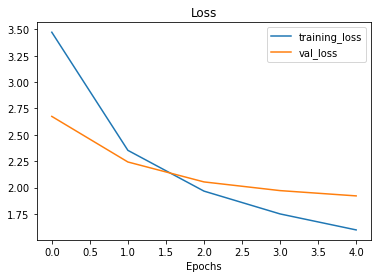

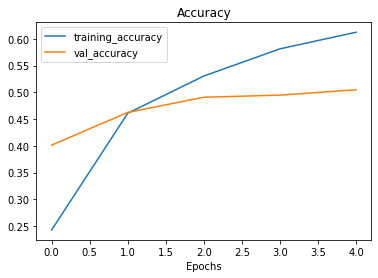

In [12]:
plot_loss_curves(history_all_classes_10_percent)

# Fine tuning the model

In [16]:
# Unfreeze some of the layer in the base model
base_model.trainable = True

# Refreeze every layers except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [17]:
# Recompile the model with lower learning reate now that some of the base model layer are trainable
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [18]:
# What layers are trainable
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_poll_layer True
output_layer True


In [19]:
#check which layers are rainable in base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)
  

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [22]:
# Fine tune for 5 more epochs
fine_tune_epochs = 10

# Fine tune model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs = fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps = int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])


Epoch 5/10
237/237 [==============================] - 82s 311ms/step - loss: 1.3599 - accuracy: 0.6491 - val_loss: 1.9143 - val_accuracy: 0.5005
Epoch 6/10
237/237 [==============================] - 72s 304ms/step - loss: 1.2379 - accuracy: 0.6762 - val_loss: 1.8734 - val_accuracy: 0.5132
Epoch 7/10
237/237 [==============================] - 71s 299ms/step - loss: 1.1423 - accuracy: 0.6957 - val_loss: 1.8922 - val_accuracy: 0.5061
Epoch 8/10
237/237 [==============================] - 66s 275ms/step - loss: 1.0839 - accuracy: 0.7126 - val_loss: 1.8996 - val_accuracy: 0.5103
Epoch 9/10
237/237 [==============================] - 66s 274ms/step - loss: 1.0191 - accuracy: 0.7306 - val_loss: 1.9239 - val_accuracy: 0.5053
Epoch 10/10
237/237 [==============================] - 64s 269ms/step - loss: 0.9614 - accuracy: 0.7447 - val_loss: 1.8766 - val_accuracy: 0.5185


In [23]:
# Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 102s 129ms/step - loss: 1.6045 - accuracy: 0.5820


[1.604501724243164, 0.5820198059082031]

In [25]:
feature_extraction_results

[1.709123134613037, 0.5581386089324951]

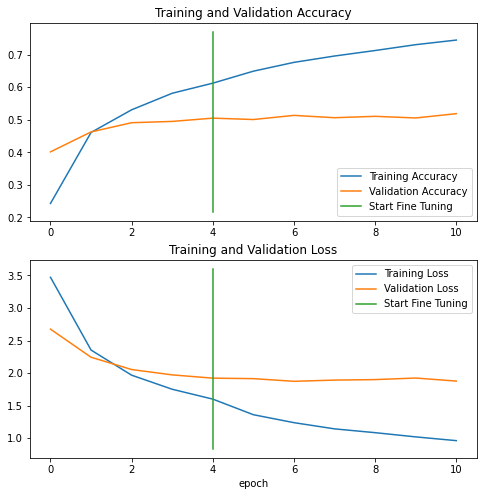

In [29]:
# compare histories
compare_historys(original_history=history_all_classes_10_percent,
                 new_history = history_all_classes_10_percent_fine_tune,
                 initial_epochs = 5)

In [30]:
## Save the fine tuned model
#model.save("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model")


INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [32]:
# Load saved model
#loaded_model = tf.keras.models.load_model("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model")

In [35]:
# check perfomance of loaded model
#loaded_model_results = loaded_model.evaluate(test_data)
#loaded_model_results

790/790 [==============================] - 105s 133ms/step - loss: 1.6045 - accuracy: 0.5820


[1.604501724243164, 0.5820198059082031]

In [34]:
# Compare with unsaved model
all_classes_10_percent_fine_tune_results

[1.604501724243164, 0.5820198059082031]

In [36]:
#download pretrained model
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2021-10-24 17:57:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.120.128, 142.250.128.128, 142.251.6.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.120.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   169MB/s    in 0.3s    

2021-10-24 17:57:17 (169 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [37]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [38]:
model_1 = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [39]:
results_downloaded_model = model_1.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 107s 133ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

In [40]:
# Make prediction with the model
pred_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 91s 114ms/step


In [41]:
len(pred_probs)

25250

In [42]:
# shape of predictions
pred_probs.shape

(25250, 101)

In [43]:
# first 10 prediction
pred_probs[:10]

array([[3.1657350e-01, 5.3057302e-05, 8.2167991e-02, ..., 6.9726346e-05,
        3.0924005e-03, 8.7807357e-02],
       [8.3875024e-01, 8.9553659e-08, 1.1728047e-03, ..., 3.0012645e-03,
        4.9667011e-07, 1.9625800e-06],
       [2.6152241e-01, 2.5422170e-03, 8.3230427e-03, ..., 9.8212843e-04,
        2.3008718e-03, 3.7660575e-03],
       ...,
       [3.0032694e-01, 2.6999949e-06, 1.8246000e-03, ..., 7.8626506e-02,
        1.0948796e-03, 2.6043519e-04],
       [1.4662312e-01, 6.7405449e-04, 5.0170232e-02, ..., 8.6614920e-04,
        6.3148902e-05, 7.3214265e-04],
       [4.9421251e-01, 1.2048130e-06, 7.9029822e-04, ..., 2.7334448e-02,
        8.0042346e-06, 4.1985046e-03]], dtype=float32)

In [44]:
pred_probs[:1]

array([[3.16573501e-01, 5.30573016e-05, 8.21679905e-02, 2.28706281e-08,
        4.12972122e-06, 2.63088532e-06, 7.16051291e-05, 3.32740660e-06,
        3.93789746e-02, 3.54193500e-04, 1.93679853e-06, 4.43772478e-06,
        2.35327892e-03, 1.94578035e-07, 5.98413646e-02, 6.65240455e-04,
        3.79851226e-05, 2.23137392e-03, 2.69145588e-03, 4.99097632e-06,
        1.96289868e-04, 3.10652395e-05, 2.14894986e-04, 3.83429491e-04,
        1.19332602e-04, 3.92187736e-04, 2.39687666e-04, 5.91984781e-06,
        1.49583235e-01, 9.29025235e-04, 7.31216278e-06, 3.74294177e-04,
        2.16731802e-03, 1.69539263e-07, 6.43067621e-03, 1.63878030e-05,
        9.89781547e-05, 2.23538998e-04, 2.63058171e-02, 2.40399950e-05,
        7.90866383e-04, 6.17131533e-04, 5.07373305e-04, 5.00413580e-06,
        3.49320471e-05, 7.78042086e-05, 3.10379965e-03, 4.33603331e-04,
        8.24590586e-07, 6.79278895e-02, 1.19396471e-04, 2.09741156e-05,
        2.83684954e-02, 1.09273857e-02, 4.88295227e-05, 2.140740

In [45]:
pred_probs[:1].shape

(1, 101)

In [56]:
print(f'Number of prediction probabilities for sample 0 = :{len(pred_probs[0])}')
print(f'What prediction probability sample 0 looks like:\n {pred_probs[0]}')
print(f'The class with the highest predicted probability by the model for sample 0 is: {pred_probs[81].argmax()}')

Number of prediction probabilities for sample 0 = :101
What prediction probability sample 0 looks like:
 [3.16573501e-01 5.30573016e-05 8.21679905e-02 2.28706281e-08
 4.12972122e-06 2.63088532e-06 7.16051291e-05 3.32740660e-06
 3.93789746e-02 3.54193500e-04 1.93679853e-06 4.43772478e-06
 2.35327892e-03 1.94578035e-07 5.98413646e-02 6.65240455e-04
 3.79851226e-05 2.23137392e-03 2.69145588e-03 4.99097632e-06
 1.96289868e-04 3.10652395e-05 2.14894986e-04 3.83429491e-04
 1.19332602e-04 3.92187736e-04 2.39687666e-04 5.91984781e-06
 1.49583235e-01 9.29025235e-04 7.31216278e-06 3.74294177e-04
 2.16731802e-03 1.69539263e-07 6.43067621e-03 1.63878030e-05
 9.89781547e-05 2.23538998e-04 2.63058171e-02 2.40399950e-05
 7.90866383e-04 6.17131533e-04 5.07373305e-04 5.00413580e-06
 3.49320471e-05 7.78042086e-05 3.10379965e-03 4.33603331e-04
 8.24590586e-07 6.79278895e-02 1.19396471e-04 2.09741156e-05
 2.83684954e-02 1.09273857e-02 4.88295227e-05 2.14074068e-02
 3.09209693e-02 5.71770477e-04 5.15773613

In [59]:
test_data.class_names[0]

'apple_pie'

In [58]:
# Get the pred classes of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look
pred_classes[:10]

array([ 0,  0,  0, 38, 29, 78, 29,  0,  9,  0])